In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import ollama  # Ollama (Phi-4) Ïó∞Í≤∞

c:\Users\korea\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Ìè∞Ìä∏ Í≤ΩÎ°ú ÏÑ§Ï†ï
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = fm.FontProperties(fname=font_path).get_name()

# Ï†ÑÏ≤¥ Í∑∏ÎûòÌîÑÏóê Ï†ÅÏö©Ìï† Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams["font.family"] = font_name

# ÏùåÏàò Í∏∞Ìò∏(-)Í∞Ä Íπ®ÏßÄÏßÄ ÏïäÎèÑÎ°ù ÏÑ§Ï†ï
plt.rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings(
    "ignore", 
    message=".*Could not find the number of physical cores.*"
)


In [3]:
# CUDA ÏÇ¨Ïö© Í∞ÄÎä• Ïó¨Î∂Ä ÌôïÏù∏
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [5]:
# ---------------------------
# 1. Train Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨
# ---------------------------
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission = pd.read_csv("LB_0.5464_mean_vector_submission.csv", encoding="utf-8-sig")

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Í∏∞Î≥∏ Íµ¨Ï°∞ ÌôïÏù∏
print("DataFrame Info:")
train_df.info()

print("\nDataFrame Head:")
print(train_df.head())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23422 entries, 0 to 23421
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               23422 non-null  object
 1   Î∞úÏÉùÏùºÏãú             23422 non-null  object
 2   ÏÇ¨Í≥†Ïù∏ÏßÄ ÏãúÍ∞Ñ          23422 non-null  object
 3   ÎÇ†Ïî®               23422 non-null  object
 4   Í∏∞Ïò®               23422 non-null  object
 5   ÏäµÎèÑ               23422 non-null  object
 6   Í≥µÏÇ¨Ï¢ÖÎ•ò             23422 non-null  object
 7   Ïó∞Î©¥Ï†Å              23422 non-null  object
 8   Ï∏µ Ï†ïÎ≥¥             23422 non-null  object
 9   Ïù∏Ï†ÅÏÇ¨Í≥†             23390 non-null  object
 10  Î¨ºÏ†ÅÏÇ¨Í≥†             21932 non-null  object
 11  Í≥µÏ¢Ö               23411 non-null  object
 12  ÏÇ¨Í≥†Í∞ùÏ≤¥             22735 non-null  object
 13  ÏûëÏóÖÌîÑÎ°úÏÑ∏Ïä§           23359 non-null  object
 14  Ïû•ÏÜå               23422 non-null  object
 15  Î∂ÄÏúÑ   


Í≤∞Ï∏°Ïπò Í∞úÏàò:
ID                    0
Î∞úÏÉùÏùºÏãú                  0
ÏÇ¨Í≥†Ïù∏ÏßÄ ÏãúÍ∞Ñ               0
ÎÇ†Ïî®                    0
Í∏∞Ïò®                    0
ÏäµÎèÑ                    0
Í≥µÏÇ¨Ï¢ÖÎ•ò                  0
Ïó∞Î©¥Ï†Å                   0
Ï∏µ Ï†ïÎ≥¥                  0
Ïù∏Ï†ÅÏÇ¨Í≥†                 32
Î¨ºÏ†ÅÏÇ¨Í≥†               1490
Í≥µÏ¢Ö                   11
ÏÇ¨Í≥†Í∞ùÏ≤¥                687
ÏûëÏóÖÌîÑÎ°úÏÑ∏Ïä§               63
Ïû•ÏÜå                    0
Î∂ÄÏúÑ                    0
ÏÇ¨Í≥†ÏõêÏù∏                 63
Ïû¨Î∞úÎ∞©ÏßÄÎåÄÏ±Ö Î∞è Ìñ•ÌõÑÏ°∞ÏπòÍ≥ÑÌöç       0
dtype: int64
ID         0
Î∞úÏÉùÏùºÏãú       0
ÏÇ¨Í≥†Ïù∏ÏßÄ ÏãúÍ∞Ñ    0
ÎÇ†Ïî®         0
Í∏∞Ïò®         0
ÏäµÎèÑ         0
Í≥µÏÇ¨Ï¢ÖÎ•ò       0
Ïó∞Î©¥Ï†Å        0
Ï∏µ Ï†ïÎ≥¥       0
Ïù∏Ï†ÅÏÇ¨Í≥†       0
Î¨ºÏ†ÅÏÇ¨Í≥†       0
Í≥µÏ¢Ö         0
ÏÇ¨Í≥†Í∞ùÏ≤¥       1
ÏûëÏóÖÌîÑÎ°úÏÑ∏Ïä§     0
Ïû•ÏÜå         0
Î∂ÄÏúÑ         0
ÏÇ¨Í≥†ÏõêÏù∏       0
dtype: int64
ÌÖçÏä§Ìä∏ Í∏∏Ïù¥ ÌèâÍ∑†: 60.18768679019725
ÌÖçÏä§Ìä∏ Í∏∏Ïù¥ 

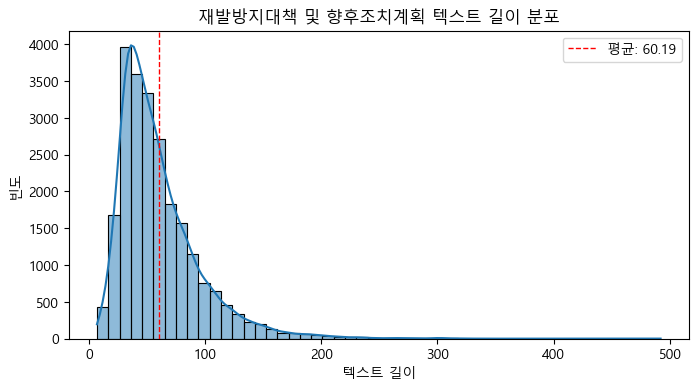

In [6]:
# Í≤∞Ï∏°Ïπò ÌôïÏù∏
print("\nÍ≤∞Ï∏°Ïπò Í∞úÏàò:")
print(train_df.isnull().sum())
print(test_df.isnull().sum())

# Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨ (ÏòàÏãú: Îπà Î¨∏ÏûêÏó¥Î°ú Ï±ÑÏö∞Í∏∞)
train_df = train_df.fillna("")
test_df = test_df.fillna("")

# ÌÉÄÍπÉ Ïª¨Îüº(Ïû¨Î∞úÎ∞©ÏßÄÎåÄÏ±Ö Î∞è Ìñ•ÌõÑÏ°∞ÏπòÍ≥ÑÌöç)Ïùò Í∏∏Ïù¥ Í≥ÑÏÇ∞
train_df["plan_length"] = train_df["Ïû¨Î∞úÎ∞©ÏßÄÎåÄÏ±Ö Î∞è Ìñ•ÌõÑÏ°∞ÏπòÍ≥ÑÌöç"].apply(len)

# ÌÖçÏä§Ìä∏ Í∏∏Ïù¥Ïùò ÌèâÍ∑†Í≥º Î∂ÑÏÇ∞ Í≥ÑÏÇ∞
mean_length = train_df["plan_length"].mean()
variance_length = train_df["plan_length"].var()
median_length = train_df["plan_length"].median()

print("ÌÖçÏä§Ìä∏ Í∏∏Ïù¥ ÌèâÍ∑†:", mean_length)
print("ÌÖçÏä§Ìä∏ Í∏∏Ïù¥ Î∂ÑÏÇ∞:", variance_length)
print("ÌÖçÏä§Ìä∏ Í∏∏Ïù¥ Ï§ëÏïôÍ∞í", median_length)
# ÌÖçÏä§Ìä∏ Í∏∏Ïù¥ Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(8, 4))
sns.histplot(train_df["plan_length"], bins=50, kde=True)
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1, label=f'ÌèâÍ∑†: {mean_length:.2f}')
plt.title("Ïû¨Î∞úÎ∞©ÏßÄÎåÄÏ±Ö Î∞è Ìñ•ÌõÑÏ°∞ÏπòÍ≥ÑÌöç ÌÖçÏä§Ìä∏ Í∏∏Ïù¥ Î∂ÑÌè¨")
plt.xlabel("ÌÖçÏä§Ìä∏ Í∏∏Ïù¥")
plt.ylabel("ÎπàÎèÑ")
plt.legend()
plt.show()

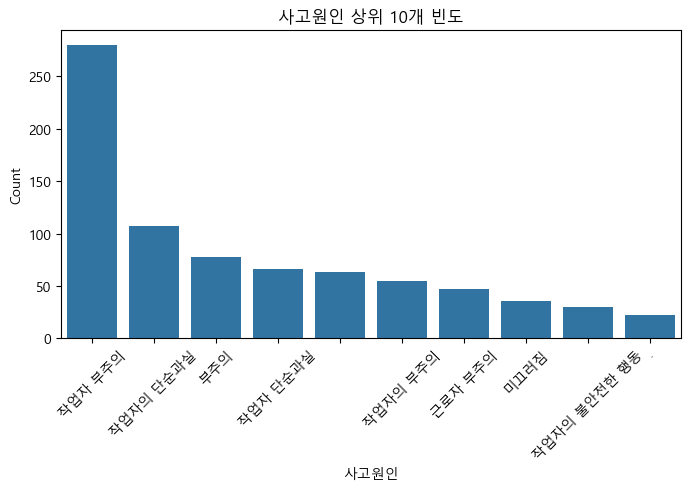

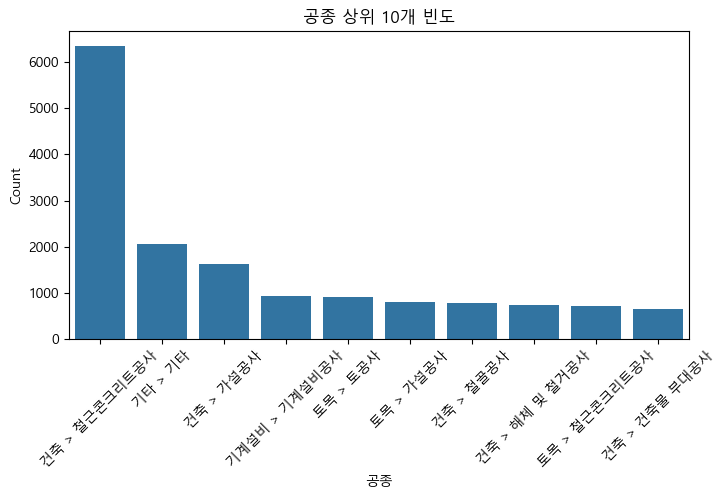

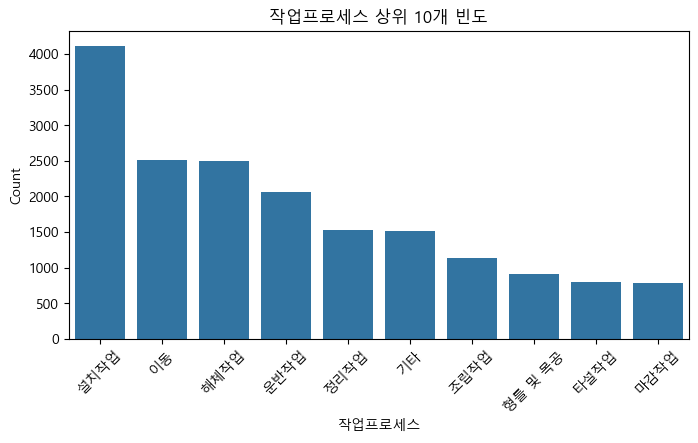

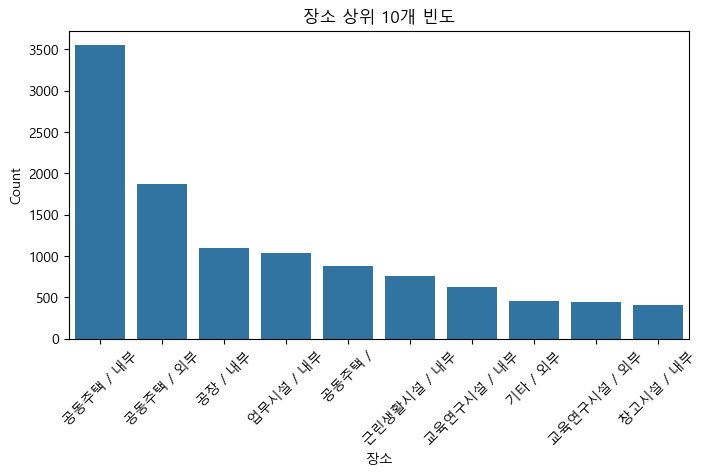

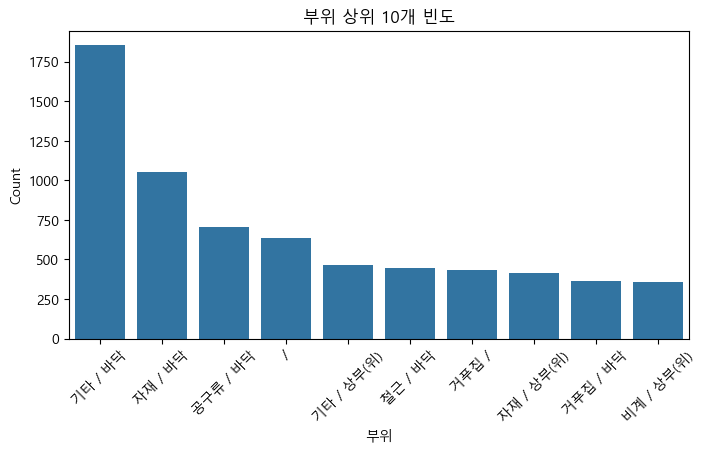

In [7]:
# Ïòà: ÏÇ¨Í≥†ÏõêÏù∏, Í≥µÏ¢Ö, ÏûëÏóÖÌîÑÎ°úÏÑ∏Ïä§, Ïû•ÏÜå, Î∂ÄÏúÑ Îì± Î≤îÏ£ºÌòï ÏπºÎüºÏùò Í∞í Î∂ÑÌè¨
categorical_cols = ["ÏÇ¨Í≥†ÏõêÏù∏", "Í≥µÏ¢Ö", "ÏûëÏóÖÌîÑÎ°úÏÑ∏Ïä§", "Ïû•ÏÜå", "Î∂ÄÏúÑ"]

for col in categorical_cols:
    value_counts = train_df[col].value_counts().head(10)  # ÏÉÅÏúÑ 10Í∞úÎßå ÏòàÏãú
    plt.figure(figsize=(8, 4))
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f"{col} ÏÉÅÏúÑ 10Í∞ú ÎπàÎèÑ")
    plt.xticks(rotation=45)
    plt.ylabel("Count")
    plt.show()


In [8]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

device = "cuda" if torch.cuda.is_available() else "cpu"
# SentenceTransformer Î™®Îç∏ Î°úÎìú (Îπ†Î•∏ ÏûÑÎ≤†Îî©ÏùÑ ÏúÑÌï¥ 'all-MiniLM-L6-v2' ÏÇ¨Ïö©)
model = SentenceTransformer("jhgan/ko-sbert-sts", device=device)

# ÌïÑÏàò Ïª¨Îüº ÌôïÏù∏
columns_needed = ["ÏÇ¨Í≥†ÏõêÏù∏", "Ïû¨Î∞úÎ∞©ÏßÄÎåÄÏ±Ö Î∞è Ìñ•ÌõÑÏ°∞ÏπòÍ≥ÑÌöç"]
if not all(col in train_df.columns for col in columns_needed):
    raise ValueError(f"ÌïÑÏàò Ïª¨Îüº {columns_needed}Ïù¥ Îç∞Ïù¥ÌÑ∞Ïóê ÏóÜÏäµÎãàÎã§.")


In [9]:
# ÌïôÏäµ Îç∞Ïù¥ÌÑ∞: ÏÇ¨Í≥†Í∞ùÏ≤¥ÏôÄ ÏÇ¨Í≥†ÏõêÏù∏ Í∞ÅÍ∞Å Î≤°ÌÑ∞Ìôî
accident_object_vectors = model.encode(train_df["ÏÇ¨Í≥†Í∞ùÏ≤¥"].tolist(), convert_to_numpy=True)
accident_cause_vectors  = model.encode(train_df["ÏÇ¨Í≥†ÏõêÏù∏"].tolist(), convert_to_numpy=True)

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞: ÏÇ¨Í≥†Í∞ùÏ≤¥ÏôÄ ÏÇ¨Í≥†ÏõêÏù∏ Í∞ÅÍ∞Å Î≤°ÌÑ∞Ìôî
test_object_vectors = model.encode(test_df["ÏÇ¨Í≥†Í∞ùÏ≤¥"].tolist(), convert_to_numpy=True)
test_cause_vectors  = model.encode(test_df["ÏÇ¨Í≥†ÏõêÏù∏"].tolist(), convert_to_numpy=True)

In [10]:
# ÏÇ¨Ïö©Ïûê ÏßÄÏ†ï Í∞ÄÏ§ëÏπò (ÏÇ¨Ïö©ÏûêÍ∞Ä Î≥ÄÍ≤Ω Í∞ÄÎä•)
object_weight = 0.25  # ÏÇ¨Í≥†Í∞ùÏ≤¥ Í∞ÄÏ§ëÏπò
cause_weight = 0.75  # ÏÇ¨Í≥†ÏõêÏù∏ Í∞ÄÏ§ëÏπò

# Ïú†ÏÇ¨ÎèÑ ÌñâÎ†¨ Í≥ÑÏÇ∞
object_similarity_matrix = cosine_similarity(accident_object_vectors)  # ÏÇ¨Í≥†Í∞ùÏ≤¥ Ïú†ÏÇ¨ÎèÑ
cause_similarity_matrix = cosine_similarity(accident_cause_vectors)  # ÏÇ¨Í≥†ÏõêÏù∏ Ïú†ÏÇ¨ÎèÑ

# ÏÇ¨Ïö©Ïûê Í∞ÄÏ§ëÏπòÎ•º Î∞òÏòÅÌïú ÏµúÏ¢Ö Ïú†ÏÇ¨ÎèÑ ÌñâÎ†¨
final_similarity_matrix = (object_weight * object_similarity_matrix) + (cause_weight * cause_similarity_matrix)


# Ïú†ÏÇ¨Ìïú ÏÇ¨Í≥† Ï∞æÍ∏∞ Ìï®Ïàò (Í∞ÄÏ§ëÏπò Î∞òÏòÅÎêú Ïú†ÏÇ¨ÎèÑ Í∏∞Ï§Ä)
def find_similar_accidents(index, top_n=5):
    """
    Ï£ºÏñ¥ÏßÑ ÏÇ¨Í≥†Ïùò Ïù∏Îç±Ïä§Î•º Í∏∞Î∞òÏúºÎ°ú Í∞ÄÏû• Ïú†ÏÇ¨Ìïú ÏÇ¨Í≥†Î•º Ï∞æÏùå.
    ÎèôÏùº ÏÇ¨Í≥†Îäî Ï†úÏô∏ÌïòÍ≥† top_nÍ∞úÎ•º Î∞òÌôò.
    """
    similarities = final_similarity_matrix[index]
    similar_indices = np.argsort(-similarities)[1:top_n+1]  # ÏûêÍ∏∞ ÏûêÏã† Ï†úÏô∏, ÏÉÅÏúÑ NÍ∞ú ÏÑ†ÌÉù
    return similar_indices, similarities[similar_indices]

# ÌäπÏ†ï ÏÇ¨Í≥†Ïóê ÎåÄÌï¥ Ïú†ÏÇ¨ ÏÇ¨Í≥† Ï∞æÍ∏∞
example_index = 0  # ÏòàÏ†ú Ïù∏Îç±Ïä§
similar_indices, similarity_scores = find_similar_accidents(example_index)

# Í≤∞Í≥º Ï∂úÎ†•
print(f"\nüîπ Í∏∞Ï§Ä ÏÇ¨Í≥†Í∞ùÏ≤¥: {train_df['ÏÇ¨Í≥†Í∞ùÏ≤¥'].iloc[example_index]}")
print(f"üîπ Í∏∞Ï§Ä ÏÇ¨Í≥†ÏõêÏù∏: {train_df['ÏÇ¨Í≥†ÏõêÏù∏'].iloc[example_index]}")
print(f"  ‚Æ© ÎåÄÏùë ÎåÄÏ±Ö: {train_df['Ïû¨Î∞úÎ∞©ÏßÄÎåÄÏ±Ö Î∞è Ìñ•ÌõÑÏ°∞ÏπòÍ≥ÑÌöç'].iloc[example_index]}\n")

for rank, (idx, score) in enumerate(zip(similar_indices, similarity_scores), start=1):
    print(f"üî∏ {rank}Î≤àÏß∏ Ïú†ÏÇ¨Ìïú ÏÇ¨Í≥† (Ïú†ÏÇ¨ÎèÑ: {score:.4f})")
    print(f"  üè∑ ÏÇ¨Í≥†Í∞ùÏ≤¥: {train_df['ÏÇ¨Í≥†Í∞ùÏ≤¥'].iloc[idx]}")
    print(f"  üõë ÏÇ¨Í≥†ÏõêÏù∏: {train_df['ÏÇ¨Í≥†ÏõêÏù∏'].iloc[idx]}")
    print(f"  ‚Æ© ÎåÄÏùë ÎåÄÏ±Ö: {train_df['Ïû¨Î∞úÎ∞©ÏßÄÎåÄÏ±Ö Î∞è Ìñ•ÌõÑÏ°∞ÏπòÍ≥ÑÌöç'].iloc[idx]}\n")



üîπ Í∏∞Ï§Ä ÏÇ¨Í≥†Í∞ùÏ≤¥: Í±¥ÏÑ§ÏûêÏû¨ > Ï≤†Í∑º
üîπ Í∏∞Ï§Ä ÏÇ¨Í≥†ÏõêÏù∏: Í≥†ÏÜåÏûëÏóÖ Ï§ë Ï∂îÎùΩ ÏúÑÌóòÏù¥ ÏûàÏùåÏóêÎèÑ Î∂àÍµ¨ÌïòÍ≥†, ÏïàÏ†ÑÎÇúÍ∞ÑÎåÄ, ÏïàÏ†ÑÍ≥†Î¶¨ Ï∞©Ïö© Îì± ÏïàÏ†ÑÏû•ÏπòÍ∞Ä ÎØ∏Ìù°ÌïòÏòÄÏùå.
  ‚Æ© ÎåÄÏùë ÎåÄÏ±Ö: Í≥†ÏÜåÏûëÏóÖ Ïãú Ï∂îÎùΩ ÏúÑÌóòÏù¥ ÏûàÎäî Î∂ÄÏúÑÏóê ÏïàÏ†ÑÏû•ÎπÑ ÏÑ§Ïπò.

üî∏ 1Î≤àÏß∏ Ïú†ÏÇ¨Ìïú ÏÇ¨Í≥† (Ïú†ÏÇ¨ÎèÑ: 0.9091)
  üè∑ ÏÇ¨Í≥†Í∞ùÏ≤¥: Í±¥ÏÑ§ÏûêÏû¨ > Ï≤†Í∑º
  üõë ÏÇ¨Í≥†ÏõêÏù∏: Í≥†ÏÜåÏûëÏóÖÏãú Ï∂îÎùΩÏóê ÎåÄÌïú ÎåÄÎπÑ ÎØ∏Ìù° (ÏïàÏ†ÑÍ≥†Î¶¨ ÎØ∏Ï≤¥Í≤∞)
  ‚Æ© ÎåÄÏùë ÎåÄÏ±Ö: Í≥†ÏÜåÏûëÏóÖ Ïãú ÏïàÏ†ÑÏûëÏóÖÎ∞©Î≤ï ÍµêÏú°, ÏïàÏ†ÑÎ≤®Ìä∏ Ï∞©Ïö© Î∞è Ï≤¥Í≤∞ ÍµêÏú°, ÏûëÏóÖÍµ¨Í∞Ñ Í¥ÄÎ¶¨Í∞êÎèÖÏûê ÏÉÅÏ£º, Í¥ÄÎ¶¨Í∞êÎèÖÏûê ÍµêÏú° Ïã§Ïãú, ÏïàÏ†ÑÍ≥†Î¶¨ Ï≤¥Í≤∞ Î∞è ÏÇ¨Í≥† Î∞úÏÉù Ïãú Î≥¥Í≥† Ï≤†Ï†ÄÎ•º ÌÜµÌïú Ïû¨Î∞ú Î∞©ÏßÄ ÎåÄÏ±Ö.

üî∏ 2Î≤àÏß∏ Ïú†ÏÇ¨Ìïú ÏÇ¨Í≥† (Ïú†ÏÇ¨ÎèÑ: 0.7944)
  üè∑ ÏÇ¨Í≥†Í∞ùÏ≤¥: Í±¥ÏÑ§ÏûêÏû¨ > Ï≤†Í∑º
  üõë ÏÇ¨Í≥†ÏõêÏù∏: Í≥†ÏÜåÏûëÏóÖ Ïãú, Í∞úÏù∏Î≥¥Ìò∏Íµ¨ Ï∞©Ïö©ÏùÑ Ï≤†Ï†ÄÌûà ÌïòÍ≥† ÏÉÅÎ∂ÄÏóê ÏïàÏ†ÑÎåÄ Î∂ÄÏ∞©ÏãúÏÑ§Ïóê ÏïàÏ†ÑÍ≥†Î¶¨ Ï≤¥Í≤∞ ÌõÑ ÏûëÏóÖÏùÑ Ïã§Ï

In [11]:
# --- 3. ÏÇ¨Ïö©Ïûê ÏßÄÏ†ï Í∞ÄÏ§ëÏπò Î∞è ÏµúÏ¢Ö Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞ (ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Í∞ÑÏùÄ Í∏∞Ï°¥ ÏΩîÎìú Ï∞∏Í≥†) ---
# (ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏóêÏÑúÏùò ÏµúÏ¢Ö Ïú†ÏÇ¨ÎèÑ ÌñâÎ†¨: Ìñ•ÌõÑ Ï∞∏Í≥†Ïö©)
object_weight = 0.25  # ÏÇ¨Í≥†Í∞ùÏ≤¥ Í∞ÄÏ§ëÏπò
cause_weight  = 0.75  # ÏÇ¨Í≥†ÏõêÏù∏ Í∞ÄÏ§ëÏπò

object_similarity_matrix = cosine_similarity(accident_object_vectors)  # (train vs train)
cause_similarity_matrix  = cosine_similarity(accident_cause_vectors)    # (train vs train)
final_similarity_matrix    = (object_weight * object_similarity_matrix) + (cause_weight * cause_similarity_matrix)

# --- 4. ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏôÄ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Í∞ÑÏùò Ïú†ÏÇ¨ÎèÑ Í≥ÑÏÇ∞ ---
# Í∞Å ÌÖåÏä§Ìä∏ ÏÉòÌîåÏóê ÎåÄÌï¥, ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏôÄÏùò Ïú†ÏÇ¨ÎèÑÎ•º Í≥ÑÏÇ∞
object_similarity_test = cosine_similarity(test_object_vectors, accident_object_vectors)
cause_similarity_test  = cosine_similarity(test_cause_vectors, accident_cause_vectors)
final_similarity_test  = (object_weight * object_similarity_test) + (cause_weight * cause_similarity_test)

def find_similar_accidents_for_test(test_index, top_n=5):
    """
    Ï£ºÏñ¥ÏßÑ ÌÖåÏä§Ìä∏ ÏÉòÌîå(test_index)Ïùò ÏÇ¨Í≥†Í∞ùÏ≤¥ Î∞è ÏÇ¨Í≥†ÏõêÏù∏Ïóê ÎåÄÌï¥,
    ÌïôÏäµ Îç∞Ïù¥ÌÑ∞(train_df)ÏóêÏÑú Í∞ÄÏû• Ïú†ÏÇ¨Ìïú ÏÇ¨Î°Ä top_nÍ∞úÎ•º Î∞òÌôòÌï©ÎãàÎã§.
    """
    similarities = final_similarity_test[test_index]
    # ÎÇ¥Î¶ºÏ∞®Ïàú Ï†ïÎ†¨ÌïòÏó¨ ÏÉÅÏúÑ top_n ÏÇ¨Î°Ä Ï∂îÏ∂ú
    similar_indices = np.argsort(-similarities)[:top_n]
    return similar_indices, similarities[similar_indices]

In [12]:
from langdetect import detect

def is_chinese(text):
    try:
        return detect(text) == "zh-cn"  # Ï§ëÍµ≠Ïñ¥ Í∞êÏßÄ
    except:
        return False  # Í∞êÏßÄ Ïã§Ìå® Ïãú ÏïàÏ†ÑÌïòÍ≤å Ï≤òÎ¶¨
    
def generate_rag_response(top_k_cases, Í∏∞Ï§Ä_ÏÇ¨Í≥†Í∞ùÏ≤¥, Í∏∞Ï§Ä_ÏÇ¨Í≥†ÏõêÏù∏):
    system_message = (
        "<|im_start|>system\n"
        "ÎãπÏã†ÏùÄ ÌïúÍµ≠Ïù∏ Í±¥ÏÑ§ ÏÇ¨Í≥† Ï†ÑÎ¨∏Í∞ÄÏûÖÎãàÎã§.\n"
        "ÏïÑÎûò ÏÇ¨Î°ÄÎì§ÏùÑ Ï∞∏Í≥†ÌïòÏó¨, ÏïàÏ†ÑÍµêÏú° Í∞ïÌôî Î∞è ÏúÑÌóòÏöîÏÜå Ï†êÍ≤ÄÏùÑ ÌÜµÌïú Ïû¨Î∞úÎ∞©ÏßÄÎåÄÏ±ÖÍ≥º Ìñ•ÌõÑ Ï°∞Ïπò Í≥ÑÌöçÏùÑ ÏûëÏÑ±Ìï¥Ïïº Ìï©ÎãàÎã§.\n"
        "Ï£ºÏñ¥ÏßÑ Ïú†ÏÇ¨ ÏÇ¨Í≥† ÏÇ¨Î°ÄÎì§ÏùÄ ÏÇ¨Í≥†Í∞ùÏ≤¥ÏôÄ ÏÇ¨Í≥†ÏõêÏù∏Ïóê Îî∞Î•∏ ÎåÄÏùë ÎåÄÏ±ÖÏù¥ Ï†úÏãúÎêòÏñ¥ ÏûàÏúºÎØÄÎ°ú, Ïù¥Î•º Ï¢ÖÌï©Ìï¥ Í∏∞Ï§Ä ÏÇ¨Í≥†Ïóê ÎßûÎäî ÏµúÏ†ÅÏùò ÎåÄÏùë ÎåÄÏ±ÖÏùÑ ÎèÑÏ∂úÌïòÏÑ∏Ïöî.\n"
        "ÌïúÍµ≠Ïñ¥Î°ú ÎåÄÎãµÌïòÏó¨Ïïº Ìï©ÎãàÎã§.\n"
        "<|im_end|>"
    )

    user_message = (
        "<|im_start|>user\n"
        "[Í∏∞Ï§Ä ÏÇ¨Í≥†]\n"
        f"- ÏÇ¨Í≥†Í∞ùÏ≤¥: {Í∏∞Ï§Ä_ÏÇ¨Í≥†Í∞ùÏ≤¥}\n"
        f"- ÏÇ¨Í≥†ÏõêÏù∏: {Í∏∞Ï§Ä_ÏÇ¨Í≥†ÏõêÏù∏}\n\n"
        "[Ïú†ÏÇ¨ ÏÇ¨Î°Ä - Í∏∞Ï°¥ ÎåÄÏùë ÎåÄÏ±ÖÎì§]:\n" +
        "\n".join([
            f"{i+1}. ÏÇ¨Í≥†Í∞ùÏ≤¥: {case[0]}, ÏÇ¨Í≥†ÏõêÏù∏: {case[1]}, ÎåÄÏùë ÎåÄÏ±Ö: {case[2]}"
            for i, case in enumerate(top_k_cases)
        ]) + "\n\n"
        "ÏúÑÏùò Ïú†ÏÇ¨ ÏÇ¨Î°ÄÎì§ÏùÑ Ï∞∏Í≥†ÌïòÏó¨, Í∏∞Ï§Ä ÏÇ¨Í≥†Ïóê ÎåÄÌïú ÏµúÏ†ÅÏùò Ïû¨Î∞úÎ∞©ÏßÄÎåÄÏ±Ö Î∞è Ìñ•ÌõÑ Ï°∞Ïπò Í≥ÑÌöçÏùÑ Ìïú Î¨∏Ïû•ÏúºÎ°ú ÏûëÏÑ±ÌïòÎêò, "
        "Î∞òÎìúÏãú \"ÎåÄÏùëÎåÄÏ±Ö:\"ÏúºÎ°ú ÏãúÏûëÌïòÎäî Ìïú Î¨∏Ïû•ÏúºÎ°ú ÎãµÎ≥ÄÌïòÏÑ∏Ïöî.\n"
        "<|im_end|>"
    )

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
    ]
    
    while True:
        response = ollama.chat(model="qwq", messages=messages)
        output = response["message"]["content"]
        
        if not is_chinese(output):  # Ï§ëÍµ≠Ïñ¥Í∞Ä ÏóÜÏúºÎ©¥ Î∞òÌôò
            return output
        
        print("‚ùå Ï§ëÍµ≠Ïñ¥ Í∞êÏßÄÎê®. Îã§Ïãú ÏöîÏ≤≠ Ï§ë...")


In [13]:
def process_test_cases_with_llm(test_df, final_similarity_test, train_df, top_n=5, output_csv="llm_results.csv"):
    """
    test_dfÏùò Í∞Å ÏÉòÌîåÏóê ÎåÄÌï¥, ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏôÄÏùò ÏµúÏ¢Ö Ïú†ÏÇ¨ÎèÑÎ•º Í∏∞Î∞òÏúºÎ°ú ÏÉÅÏúÑ Ïú†ÏÇ¨ ÏÇ¨Î°Ä(top_n)Î•º Ï∂îÏ∂úÌïú ÌõÑ,
    generate_rag_response Ìï®ÏàòÎ•º Ìò∏Ï∂úÌïòÏó¨ LLM(QWQ32B) Í≤∞Í≥º(ÏµúÏ†ÅÏùò Ïû¨Î∞úÎ∞©ÏßÄÎåÄÏ±Ö Î∞è Ìñ•ÌõÑ Ï°∞Ïπò Í≥ÑÌöç)Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§.
    Í≤∞Í≥ºÎäî ÏΩòÏÜîÏóê Ï∂úÎ†•ÌïòÍ≥†, CSV ÌååÏùºÎ°ú Ï†ÄÏû•Ìï©ÎãàÎã§.
    """
    results = []  # LLM Í≤∞Í≥º Ï†ÄÏû• Î¶¨Ïä§Ìä∏

    # test_dfÏùò Í∞Å ÏÉòÌîåÏóê ÎåÄÌï¥ Ï≤òÎ¶¨
    for test_idx in tqdm(range(len(test_df)), desc="Processing test cases with LLM"):
        # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏôÄÏùò ÏµúÏ¢Ö Ïú†ÏÇ¨ÎèÑÏóêÏÑú ÏÉÅÏúÑ top_n ÏÇ¨Î°Ä Ï∂îÏ∂ú (ÎÇ¥Î¶ºÏ∞®Ïàú Ï†ïÎ†¨)
        similarities = final_similarity_test[test_idx]
        similar_indices = np.argsort(-similarities)[:top_n]
        
        # ÏÉÅÏúÑ Ïú†ÏÇ¨ ÏÇ¨Î°ÄÏóê ÎåÄÌïú (ÏÇ¨Í≥†Í∞ùÏ≤¥, ÏÇ¨Í≥†ÏõêÏù∏, ÎåÄÏùë ÎåÄÏ±Ö) ÌäúÌîå Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
        top_k_cases = [
            (
                train_df.iloc[i]["ÏÇ¨Í≥†Í∞ùÏ≤¥"],
                train_df.iloc[i]["ÏÇ¨Í≥†ÏõêÏù∏"],
                train_df.iloc[i]["Ïû¨Î∞úÎ∞©ÏßÄÎåÄÏ±Ö Î∞è Ìñ•ÌõÑÏ°∞ÏπòÍ≥ÑÌöç"]
            )
            for i in similar_indices
        ]
        
        Í∏∞Ï§Ä_ÏÇ¨Í≥†Í∞ùÏ≤¥ = test_df.iloc[test_idx]["ÏÇ¨Í≥†Í∞ùÏ≤¥"]
        Í∏∞Ï§Ä_ÏÇ¨Í≥†ÏõêÏù∏   = test_df.iloc[test_idx]["ÏÇ¨Í≥†ÏõêÏù∏"]
        
        # LLM ÌîÑÎ°¨ÌîÑÌä∏Ïóê Îî∞Îùº ÏµúÏ†Å ÎåÄÏùë ÎåÄÏ±Ö ÏÉùÏÑ±
        rag_result = generate_rag_response(top_k_cases, Í∏∞Ï§Ä_ÏÇ¨Í≥†Í∞ùÏ≤¥, Í∏∞Ï§Ä_ÏÇ¨Í≥†ÏõêÏù∏)
        results.append(rag_result)
        
        # # ÏΩòÏÜî Ï∂úÎ†• (Í∞Å ÌÖåÏä§Ìä∏ ÏÉòÌîå Î≥Ñ ÏÉÅÏÑ∏ Ï†ïÎ≥¥)
        # print(f"--- Test Sample {test_idx} ---")
        # print(f"ÌÖåÏä§Ìä∏ ÏÇ¨Í≥†Í∞ùÏ≤¥: {Í∏∞Ï§Ä_ÏÇ¨Í≥†Í∞ùÏ≤¥}")
        # print(f"ÌÖåÏä§Ìä∏ ÏÇ¨Í≥†ÏõêÏù∏: {Í∏∞Ï§Ä_ÏÇ¨Í≥†ÏõêÏù∏}")
        # print("Ïú†ÏÇ¨ ÌïôÏäµ ÏÇ¨Î°Ä:")
        # for rank, i in enumerate(similar_indices, start=1):
        #     print(f"  {rank}. ÏÇ¨Í≥†Í∞ùÏ≤¥: {train_df.iloc[i]['ÏÇ¨Í≥†Í∞ùÏ≤¥']}")
        #     print(f"     ÏÇ¨Í≥†ÏõêÏù∏: {train_df.iloc[i]['ÏÇ¨Í≥†ÏõêÏù∏']}")
        #     print(f"     ÎåÄÏùë ÎåÄÏ±Ö: {train_df.iloc[i]['Ïû¨Î∞úÎ∞©ÏßÄÎåÄÏ±Ö Î∞è Ìñ•ÌõÑÏ°∞ÏπòÍ≥ÑÌöç']}")
        #     print(f"     Ïú†ÏÇ¨ÎèÑ: {similarities[i]:.4f}")
        # print("=== LLM ÏµúÏ¢Ö Í≤∞Í≥º ===")
        # print(rag_result)
        # print("\n" + "-"*80 + "\n")
    
    # test_dfÏóê LLM Í≤∞Í≥ºÎ•º Ï∂îÍ∞ÄÌïòÍ≥† CSV ÌååÏùºÎ°ú Ï†ÄÏû•
    results_df = test_df.copy()
    results_df["LLM_Í≤∞Í≥º"] = results
    results_df.to_csv(output_csv, index=False, encoding="utf-8-sig")
    print(f"LLM Í≤∞Í≥ºÍ∞Ä '{output_csv}' ÌååÏùºÏóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")
    
    return results_df

In [14]:
results_df = process_test_cases_with_llm(test_df, final_similarity_test, train_df, top_n=5, output_csv="llm_results.csv")

Processing test cases with LLM: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 964/964 [17:00:18<00:00, 63.50s/it]   

LLM Í≤∞Í≥ºÍ∞Ä 'llm_results.csv' ÌååÏùºÏóê Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.


In [15]:
import re
# Step 0: ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Í∏∏Ïù¥ ÌôïÏù∏
print("Initial length of results_df:", len(results_df))

# Í∏∞Î≥∏ ÎãµÎ≥Ä (threshold ÎØ∏ÎßåÏùò Í≤ΩÏö∞ ÏÇ¨Ïö©Îêú Í∞í)
default_answer = "ÏûëÏóÖÏ†Ñ ÏïàÏ†ÑÍµêÏú° Í∞ïÌôî Î∞è ÏûëÏóÖÏû• ÏúÑÌóòÏöîÏÜå Ï†êÍ≤ÄÏùÑ ÌÜµÌïú Ïû¨Î∞ú Î∞©ÏßÄÏôÄ ÏïàÏ†ÑÍ¥ÄÎ¶¨ ÍµêÏú° Ï≤†Ï†ÄÎ•º ÌÜµÌïú Ìñ•ÌõÑ Ï°∞Ïπò Í≥ÑÌöç."

def clean_response(text):
    """
    LLMÏúºÎ°ú ÏÉùÏÑ±Îêú ÏùëÎãµ ÌÖçÏä§Ìä∏ÏóêÏÑú <think></think> ÌÉúÍ∑∏ ÎÇ¥Î∂Ä ÎÇ¥Ïö©ÏùÑ Ï†úÍ±∞ÌïòÍ≥†,
    'ÎåÄÏùëÎåÄÏ±Ö:' Ïù¥ÌõÑÏùò Î¨∏Ïû•Îßå Ï∂îÏ∂úÌï©ÎãàÎã§.
    Í∑∏Î¶¨Í≥† Î¨∏Ïû• ÎÅùÏù¥ "ÌïúÎã§." ÎòêÎäî "ÏûÖÎãàÎã§."Î°ú ÎÅùÎÇòÎ©¥ Îã®Ïàú ÎßàÏπ®Ìëú '.'Î°ú Î≥ÄÍ≤ΩÌï©ÎãàÎã§.
    """
    # <think>...</think> ÌÉúÍ∑∏ÏôÄ Í∑∏ ÎÇ¥Î∂Ä ÎÇ¥Ïö© Ï†úÍ±∞ (DOTALL ÌîåÎûòÍ∑∏ ÏÇ¨Ïö©)
    cleaned = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL)
    # 'ÎåÄÏùëÎåÄÏ±Ö:' Ïù¥ÌõÑÏùò Î¨∏Ïû•ÏùÑ Ï∂îÏ∂ú (Ï°¥Ïû¨ÌïòÎ©¥)
    if "ÎåÄÏùëÎåÄÏ±Ö:" in cleaned:
        cleaned = cleaned.split("ÎåÄÏùëÎåÄÏ±Ö:")[-1].strip()
    # Î¨∏Ïû• ÎÅùÏóê "ÌïúÎã§." ÎòêÎäî "ÏûÖÎãàÎã§."Í∞Ä ÏûàÏúºÎ©¥ '.'Î°ú ÏπòÌôò
    cleaned = re.sub(r'(ÌïúÎã§|ÏûÖÎãàÎã§)\.\s*$', '.', cleaned)
    return cleaned

# Step 1: LLM ÏùëÎãµ Í≤∞Í≥º Ï†ïÏ†ú (default_answerÍ∞Ä ÏïÑÎãå Ìï≠Î™©Ïóê ÎåÄÌï¥)
cleaned_test_results = []
for res in results_df["LLM_Í≤∞Í≥º"]:
    if res != default_answer and "ÎåÄÏùëÎåÄÏ±Ö:" in res:
        cleaned_test_results.append(clean_response(res))
    else:
        cleaned_test_results.append(res)

print("Length of cleaned_test_results:", len(cleaned_test_results))

# ---------------------------------------------------
# Step 7: Í≤∞Í≥º Î≤°ÌÑ∞Ìôî (Ï†úÏ∂úÏùÑ ÏúÑÌï¥ `jhgan/ko-sbert-sts` ÏÇ¨Ïö©)
# ---------------------------------------------------
# device ÏÑ§Ï†ï (GPU ÏÇ¨Ïö© Ïãú "cuda", ÏóÜÏúºÎ©¥ "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
submission_embedding_model = SentenceTransformer("jhgan/ko-sbert-sts", device=device)

pred_embeddings = []
for i in tqdm(range(0, len(cleaned_test_results), 64), desc="Encoding Submission Results"):
    batch = cleaned_test_results[i : i + 64]
    batch_vectors = submission_embedding_model.encode(batch, convert_to_numpy=True, show_progress_bar=False)
    pred_embeddings.extend(batch_vectors)

print("Length of pred_embeddings:", len(pred_embeddings))

# ---------------------------------------------------
# Step 8: ÏµúÏ¢Ö Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±
# ---------------------------------------------------
# test_dfÏóê "ID" Ïª¨ÎüºÏù¥ Ï°¥Ïû¨ÌïúÎã§Í≥† Í∞ÄÏ†ï (ÏóÜÏúºÎ©¥ Ìï¥Îãπ Ïª¨ÎüºÎ™ÖÏùÑ ÏàòÏ†ï)
submission = test_df[["ID"]].copy()
print("Length of submission (before adding responses):", len(submission))
print("Length of cleaned_test_results (should match submission length):", len(cleaned_test_results))

submission["Ïû¨Î∞úÎ∞©ÏßÄÎåÄÏ±Ö Î∞è Ìñ•ÌõÑÏ°∞ÏπòÍ≥ÑÌöç"] = cleaned_test_results

# ÏòàÏ∏° Î≤°ÌÑ∞Î•º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Î≥ÄÌôò (Í∞Å Ïó¥ÏùÄ ÏûÑÎ≤†Îî© Ï∞®Ïõê)
submission_embedding_df = pd.DataFrame(pred_embeddings)
print("Shape of submission_embedding_df:", submission_embedding_df.shape)

# Îëê Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î≥ëÌï© (ID, ÎåÄÏùë ÎåÄÏ±Ö, Î≤°ÌÑ∞ Ïª¨Îüº)
submission = pd.concat([submission, submission_embedding_df], axis=1)
print("Final submission shape:", submission.shape)

# cleaned_test_results Î¶¨Ïä§Ìä∏ ÎÇ¥ NaN Ï≤¥ÌÅ¨
nan_indices = [i for i, x in enumerate(cleaned_test_results) if pd.isna(x)]
if nan_indices:
    print("cleaned_test_resultsÏóêÏÑú NaNÏù¥ Î∞úÍ≤¨Îêú Ïù∏Îç±Ïä§:", nan_indices)
else:
    print("cleaned_test_resultsÏóê NaNÏù¥ ÏóÜÏäµÎãàÎã§.")

# submission DataFrame ÎÇ¥ NaN Ï≤¥ÌÅ¨
if submission.isnull().values.any():
    print("submission DataFrameÏóê NaN Í∞íÏù¥ ÏûàÏäµÎãàÎã§:")
    print(submission.isnull().sum())
else:
    print("submission DataFrameÏóê NaN Í∞íÏù¥ ÏóÜÏäµÎãàÎã§.")

# ---------------------------------------------------
# Step 9: Í≤∞Í≥º Ï†ÄÏû•
# ---------------------------------------------------
submission_path = "QWQ_object_rag_submission.csv"
print("Preview of submission DataFrame:")
print(submission.head())
submission.to_csv(submission_path, index=False, encoding="utf-8-sig")

Initial length of results_df: 964
Length of cleaned_test_results: 964


Encoding Submission Results: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:01<00:00, 11.02it/s]


Length of pred_embeddings: 964
Length of submission (before adding responses): 964
Length of cleaned_test_results (should match submission length): 964
Shape of submission_embedding_df: (964, 768)
Final submission shape: (964, 770)
cleaned_test_resultsÏóê NaNÏù¥ ÏóÜÏäµÎãàÎã§.
submission DataFrameÏóê NaN Í∞íÏù¥ ÏóÜÏäµÎãàÎã§.
Preview of submission DataFrame:
         ID                                    Ïû¨Î∞úÎ∞©ÏßÄÎåÄÏ±Ö Î∞è Ìñ•ÌõÑÏ°∞ÏπòÍ≥ÑÌöç         0  \
0  TEST_000  ÏßÄÎ∞ò Ïπ®Ìïò ÏòàÎ∞©ÏùÑ ÏúÑÌï¥ ÏïÑÏõÉÌä∏Î¶¨Í±∞ ÏÑ§Ïπò Ï†Ñ Í≥†Î∞ÄÎèÑ ÏßÄÎ∞òÏù¥ÎÇò Í∞ïÌôî Î∞õÏπ®Íµ¨Ï°∞Î¨º ÏÇ¨Ïö© Ïùò... -0.599011   
1  TEST_001  ÏûëÏóÖÏûêÏùò Ïà´Îèå Ï∏°Î©¥ ÏÇ¨Ïö© Î∞©ÏßÄÎ•º ÏúÑÌïú ÌäπÎ≥ÑÏïàÏ†ÑÍµêÏú° Ïã§ÏãúÏôÄ ÏïàÏ†ÑÎ©¥(Î≥¥Ìò∏Î©¥Ìåê) ÏùòÎ¨¥Ï∞©Ïö©... -0.141440   
2  TEST_002  ÏïàÏ†ÑÍµêÏú° Í∞ïÌôîÏôÄ Í≥ÑÎã® ÌÜµÌñâÎ°úÏùò Ï†ïÍ∏∞Ï†Å Ï†êÍ≤ÄÏùÑ ÌÜµÌï¥ ÎØ∏ÎÅÑÎü¨ÏõÄ Î∞è Ïû•Ïï†Î¨º Ï†úÍ±∞, Î≥¥ÌñâÏ£º... -0.330941   
3  TEST_003  ÏûëÏóÖ Î∞úÌåê ÏúÑ Î≤ΩÎèå ÏûîÏû¨ Ï¶âÏãú Ï†úÍ±∞ Î∞è Ï£ºÍ∏∞Ï†Å ÏïàÏ†ÑÍµêÏú° Í∞ïÌôî, ÌòÑÏû• Í¥ÄÎ

In [16]:
from dacon_submit_api import dacon_submit_api

result = dacon_submit_api.post_submission_file(
'QWQ_object_rag_submission.csv', 
'your_dacon_api_key', 
'236455', 
'mutoy', 
'QWQ32B_clean' )

{'isSubmitted': True, 'detail': 'Success'}
